# Load Library/Dataset

In [2]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, OrdinalEncoder
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
import shap
import matplotlib.pyplot as plt
import xgboost as xgb
from sklearn.metrics import classification_report, confusion_matrix
import json

# Load the labeled dataset
df = pd.read_csv('labeled_applicants_data.csv')
df = df.drop(columns=["Maklumat Isi Rumah"])

# Data Overview

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15000 entries, 0 to 14999
Data columns (total 46 columns):
 #   Column                                        Non-Null Count  Dtype  
---  ------                                        --------------  -----  
 0   Kategori Asnaf                                15000 non-null  object 
 1   Dokumen Lampiran Utama                        15000 non-null  object 
 2   Kategori pemohon                              15000 non-null  object 
 3   Sebab Memohon Bantuan                         15000 non-null  object 
 4   No. K/P (baru)/Polis/Tentera/No. Pasport      15000 non-null  object 
 5   Nama Pemohon/Institusi                        15000 non-null  object 
 6   Alamat                                        15000 non-null  object 
 7   Daerah                                        15000 non-null  object 
 8   Poskod                                        15000 non-null  int64  
 9   Bandar                                        15000 non-null 

# Data Preprocessing

Flagging Presence of Each Document as their own separate columns.

In [9]:
# List of documents to flag
DOCUMENT_LIST = [
    "Salinan KP Pemohon", "Salinan KP Pasangan", "Salinan KP Tanggungan",
    "Kad Islam", "Penyata Bank", "Sijil Nikah/Cerai/Mati",
    "Slip Gaji", "Kad OKU", "Bil Utiliti", "Penyata KWSP",
    "Sokongan Tambahan"
]

# Function to flag presence of documents
def flag_documents(dokumen_string):
    flags = {doc: (doc in dokumen_string) for doc in DOCUMENT_LIST}
    return pd.Series(flags)

# Apply the function and create new columns
df_flags = df["Dokumen Lampiran Utama"].apply(flag_documents)

# Concatenate the original DataFrame with the flags DataFrame
df = pd.concat([df, df_flags], axis=1)

Dropping the list of documents since they are flagged.

In [10]:
df = df.drop(columns=["Dokumen Lampiran Utama"])

Preprocessing JSON columns into their own separate columns. (Sumber Pendapatan Suami, Diri, etc)

In [11]:

# Step 1: Convert JSON-like strings to dictionaries
df["Sumber Pendapatan Bulanan"] = df["Sumber Pendapatan Bulanan"].apply(json.loads)

# Step 2: Normalize the data into a DataFrame
income_df = pd.json_normalize(df["Sumber Pendapatan Bulanan"])

# Step 3: Prepend "Sumber Pendapatan " to each column name
income_df.columns = [f"Sumber Pendapatan {col}" for col in income_df.columns]

# Step 4: Concatenate with the original DataFrame
df = pd.concat([df.drop(columns=["Sumber Pendapatan Bulanan"]), income_df], axis=1)

The same process for another JSON (Perbelanjaan Bulanan)

In [12]:
# Step 1: Convert JSON-like strings to dictionaries
df["Perbelanjaan Bulanan"] = df["Perbelanjaan Bulanan"].apply(json.loads)

# Step 2: Normalize the data into a DataFrame
expenses_df = pd.json_normalize(df["Perbelanjaan Bulanan"])

# Step 3: Prepend "Perbelanjaan " to each column name
expenses_df.columns = [f"Perbelanjaan {col}" for col in expenses_df.columns]

# Step 4: Concatenate with the original DataFrame
df = pd.concat([df.drop(columns=["Perbelanjaan Bulanan"]), expenses_df], axis=1)

Just to verify

In [13]:
data_types = df.dtypes.tolist()
columns = df.columns.tolist()
for column, dtype in zip(columns, data_types):
    print(f"{column}: {dtype}")

Kategori Asnaf: object
Kategori pemohon: object
Sebab Memohon Bantuan: object
No. K/P (baru)/Polis/Tentera/No. Pasport: object
Nama Pemohon/Institusi: object
Alamat: object
Daerah: object
Poskod: int64
Bandar: object
Negeri: object
Kariah: object
Warganegara: object
Emel: object
No. Telefon Bimbit: object
No. Telefon Rumah/Waris: object
Nama waris: object
Tempoh Menetap di Selangor: int64
Jantina: object
Kesihatan: object
Status: object
Poligami: float64
Nama Pemegang Akaun: object
Bank: object
No. Akaun Bank: int64
Cara Pembayaran: object
Sebab Pembayaran Tunai: object
Nama Si Mati: object
No. Kad Pengenalan Si Mati: object
Pekerjaan: object
Jawatan: object
Nama Majikan: object
No. Tel. Majikan: object
Sebab Tidak Bekerja: object
Sektor: object
Jenis Kerja Sendiri: object
Hubungan kekeluargaan dengan kakitangan LZS?: object
Nama Kakitangan: object
Pejabat (Kakitangan Berhubungan): object
Hubungan: object
Jawatan (Kakitangan Berhubungan): object
Days Since: int64
Age: int64
is_fraud: i

# Training Pipeline + Explaining with SHAP

There are 36 categorical cols and 20 numerical cols


/Users/muhdsafrul/Desktop/Dev/Repositories/MuamalatGo/.venv/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [21:58:39] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Confusion Matrix:
[[1948   62]
 [  36  954]]

Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.97      0.98      2010
           1       0.94      0.96      0.95       990

    accuracy                           0.97      3000
   macro avg       0.96      0.97      0.96      3000
weighted avg       0.97      0.97      0.97      3000

Generating SHAP summary plot...


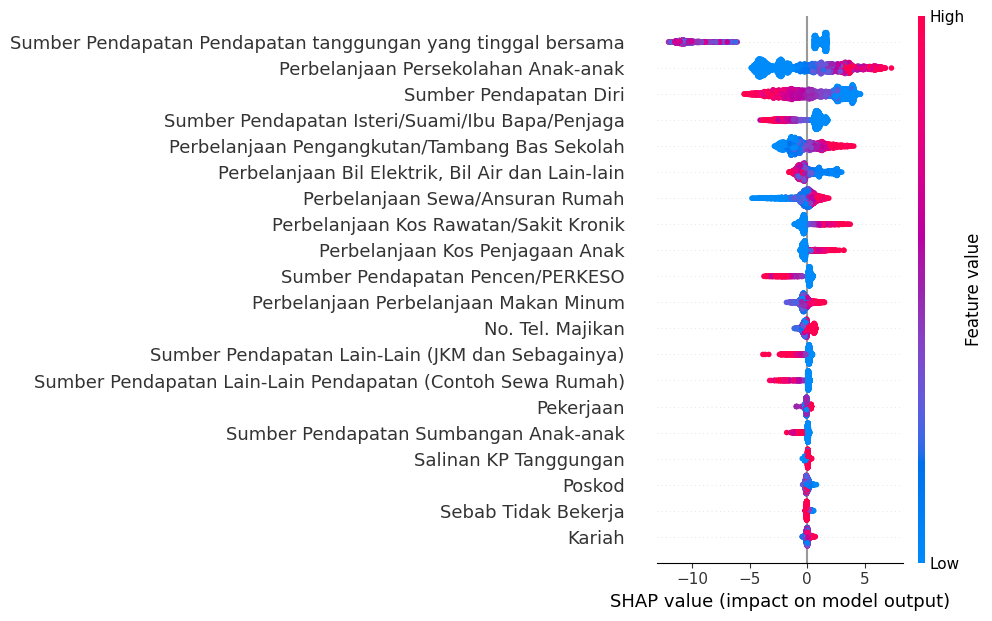

Waterfall plot for test sample index 0:


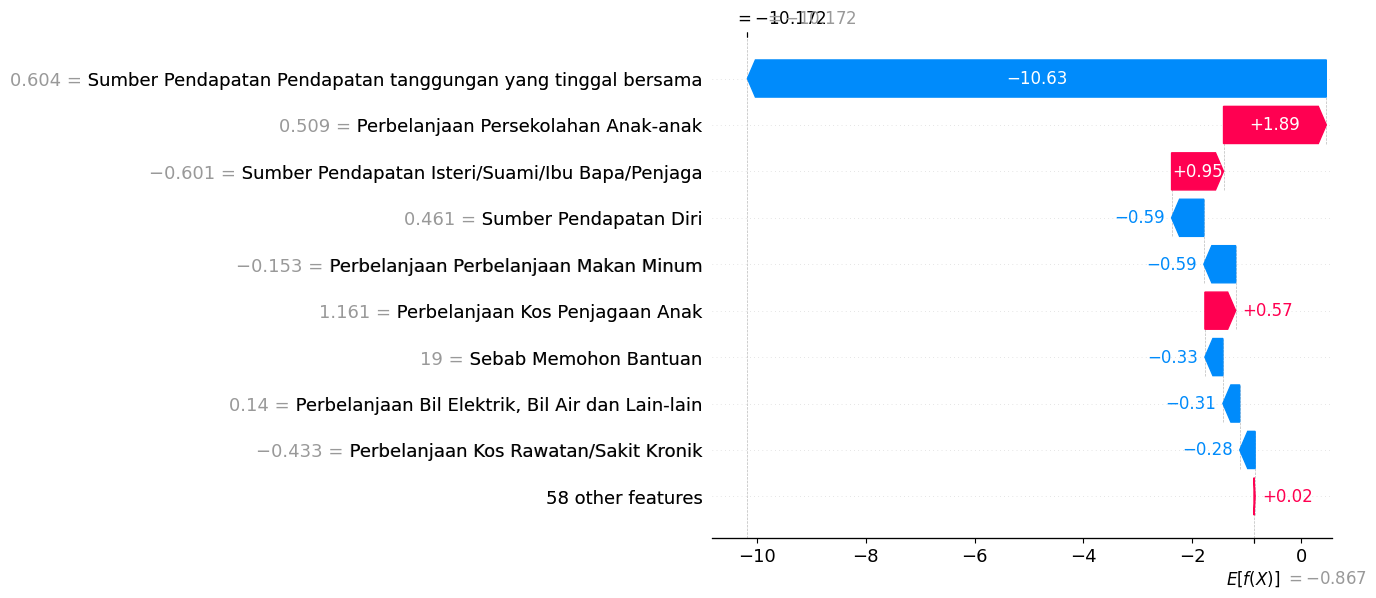

In [14]:
# Separate categorical columns
cat_cols = df.select_dtypes(include='object').columns

# Separate numerical columns, excluding 'is_fraud'
num_cols = df.select_dtypes(include='number').columns.difference(['is_fraud'])

# Fill missing values
df[cat_cols] = df[cat_cols].fillna('Unknown')
df[num_cols] = df[num_cols].fillna(df[num_cols].mean())

print(f"There are {len(cat_cols)} categorical cols and {len(num_cols)} numerical cols")

# Encode categorical features
encoder = OrdinalEncoder()
df[cat_cols] = encoder.fit_transform(df[cat_cols])

# Define features (excluding the target variable) and target
X = df.drop(columns=['is_fraud'])  # Drop the target variable
y = df['is_fraud']  # Target remains unchanged

# Scale numerical data (only features, not labels)
scaler = StandardScaler()
X[num_cols] = scaler.fit_transform(X[num_cols])  # Scale only numerical features

# Step 2: Split the preprocessed features (X) into train/test
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Step 3: Build XGBoost classifier directly
pipeline = Pipeline(steps=[
    ('classifier', xgb.XGBClassifier(
        n_estimators=100,
        use_label_encoder=False,
        eval_metric='logloss',
        random_state=42
    ))
])

# Step 4: Fit XGBoost model
pipeline.fit(X_train, y_train)

# Step 5: Evaluate the model
y_pred = pipeline.predict(X_test)
y_pred_proba = pipeline.predict_proba(X_test)[:, 1]

# Print the evaluation results
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# Step 6: Explain model predictions using SHAP
def explain_with_shap(pipeline, test_data, sample_index=0):
    model = pipeline.named_steps['classifier']

    # Use TreeExplainer directly for XGBoost
    explainer = shap.Explainer(model)
    shap_values = explainer(test_data)

    fig = plt.figure()

    # SHAP Summary Plot
    print("Generating SHAP summary plot...")
    shap.summary_plot(shap_values, features=test_data, feature_names=test_data.columns, show=False)

    plt.gcf().set_size_inches(20,6)
    plt.show()

    # SHAP Waterfall Plot for one instance
    print(f"Waterfall plot for test sample index {sample_index}:")
    shap.plots.waterfall(shap_values[sample_index])

# Call the SHAP explanation function
explain_with_shap(
    pipeline,
    test_data=X_test,
    sample_index=0
)
